In [24]:
include("lib/Nto1.jl")

using Revise … ✔
using Units, Nto1AdEx, ConnectionTests, ConnTestEval, MemDiskCache … ✔
using StatsBase … ✔


In [25]:
N = 6500
duration = 10minutes

600

In [27]:
@time sim = Nto1AdEx.sim(N, duration);

  2.564340 seconds (21.50 k allocations: 912.268 MiB, 10.99% gc time)


We won't test all 6500 inputs (and also not the highest firing), but a random sample.

In [28]:
((_, exc),
 (_, inh),
 (_, unc)) = inputs = get_trains_to_test(sim, Nₜ = length(sim.trains));

In [29]:
all_trains = [exc; inh; unc]
length(all_trains)

13000

In [ ]:
all_trains = [exc; inh; unc]
tvals = []
@showprogress for train in all_trains
    push!(tvals, STA_test(sim.V, train.times))
end

(Runtime: 06:51 with 7 threads (and lil interruption). But not threadsafe, adding to a list).\
Single threaded: 09:49.

In [10]:
include("lib/plot.jl")

import PythonCall … ✔ (1.2 s)
import PythonPlot … ✔ (2.7 s)
using Sciplotlib … ✔ (0.3 s)
using PhDPlots … ✔


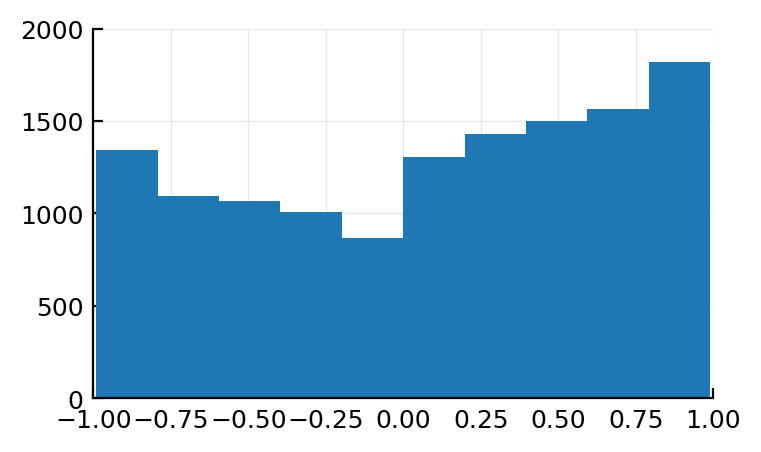

In [11]:
plt.hist(tvals);

In [12]:
θ = quantile(tvals, 0.99)

0.99

In [13]:
sel_trains = all_trains[tvals .≥ θ];

In [14]:
length(sel_trains)

180

In [15]:
STA(train) = calc_STA(sim.V, train.times, ConnectionTests.Δt, 1000);

In [16]:
average(X) = sum(X) / length(X)
template = average([STA(t) for t in sel_trains]);

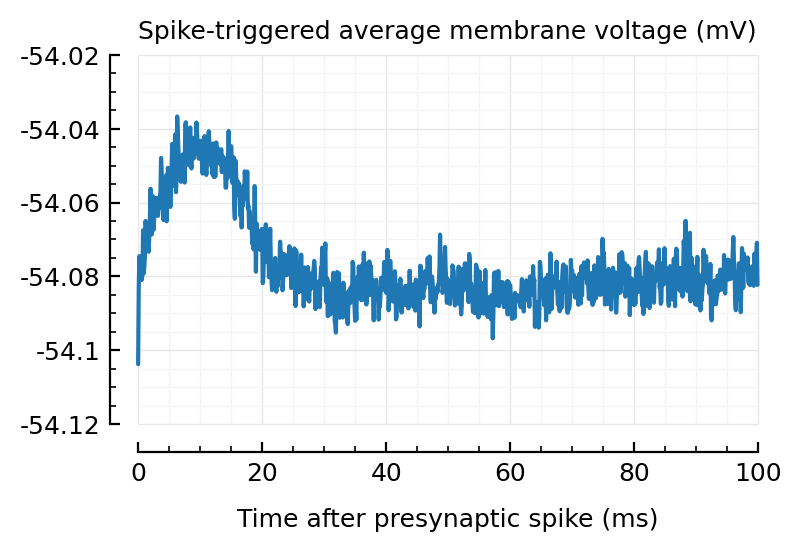

In [17]:
plotSTA(template);

Nice. (We'll only use the first 20 ms of this).

In [18]:
W = ConnectionTests.STA_length

200

In [19]:
template = template[1:W];

In [20]:
m = TemplateCorr(template);

In [ ]:
tvals2 = []
@showprogress for train in all_trains
    push!(tvals2, test_conn(m, sim.V, train.times))
end;

In [33]:
Ns = [5, 20, 100, 400, 1600, 6500]
seeds = 1:5;

In [ ]:
rows = []
for N in Ns
    for seed in seeds
        @show N seed
        sim = Nto1AdEx.sim(N, duration; seed);
        ((_, exc),
         (_, inh),
         (_, unc)) = inputs = get_trains_to_test(sim, Nₜ = length(sim.trains));
        all_trains = [exc; inh; unc]
        tvals = []
        @showprogress "pass1" for train in all_trains
            push!(tvals, STA_test(sim.V, train.times))
        end
        θ = quantile(tvals, 0.99)
        sel_trains = all_trains[tvals .≥ θ]
        template = average([STA(t) for t in sel_trains])
        template = template[1:W]
        m = TemplateCorr(template)
        tvals2 = []
        @showprogress "pass2" for train in all_trains
            push!(tvals2, test_conn(m, sim.V, train.times))
        end
        push!(rows, (; N, seed, θ, N_sel=length(sel_trains), tvals, tvals2, inputs))
    end
end;

N = 5
seed = 1
pass1 100%|██████████████████████████████████████████████| Time: 0:00:01
pass2 100%|██████████████████████████████████████████████| Time: 0:00:01
N = 5
seed = 2
pass1 100%|██████████████████████████████████████████████| Time: 0:00:00
pass2 100%|██████████████████████████████████████████████| Time: 0:00:00
N = 5
seed = 3
pass1 100%|██████████████████████████████████████████████| Time: 0:00:01
pass2 100%|██████████████████████████████████████████████| Time: 0:00:01
N = 5
seed = 4
pass1 100%|██████████████████████████████████████████████| Time: 0:00:01
pass2 100%|██████████████████████████████████████████████| Time: 0:00:01
N = 5
seed = 5
pass1 100%|██████████████████████████████████████████████| Time: 0:00:01
pass2 100%|██████████████████████████████████████████████| Time: 0:00:01
N = 20
seed = 1
pass1 100%|██████████████████████████████████████████████| Time: 0:00:02
pass2 100%|██████████████████████████████████████████████| Time: 0:00:02
N = 20
seed = 2
pass1 100%|██████

Total time very approx: 1h10

In [56]:
MemDiskCache.set_dir("2024-05-26__Fix_template-based_method")

"C:\\Users\\tfiers\\.julia\\MemDiskCache.jl\\2024-05-26__Fix_template-based_method"

In [63]:
Base.summarysize(rows) / 2^30  # GiB

1.55

In [64]:
rowsc = @cached rows;

[ Info: Loading `rows` from memory


In [79]:
perfrows = []
for row in rowsc
    (; N, seed, inputs, tvals2) = row
    tvals = Vector{Float64}(tvals2)
    conntypes = Symbol[]
    for (conntype, train) in inputs
        push!(conntypes, conntype)
    end
    sweep = sweep_threshold(tvals, conntypes)
    AUC = calc_AUROCs(sweep).AUC
    F1max = maximum(skipnan(sweep.F1))
    push!(perfrows, (; N, seed, AUC, F1max))
end;

In [65]:
include("lib/df.jl")

using DataFrames … ✔ (1.6 s)


In [86]:
df = DataFrame(perfrows);

In [85]:
gdf = groupby(df, :N)
combine(gdf, [:AUC, :F1max] .=> mean)

Row,N,AUC_mean,F1max_mean
,Int64,Float64,Float64
1,5,0.25,0.4
2,20,0.25,0.4
3,100,0.25,0.4
4,400,0.25,0.4
5,1600,0.25,0.4
6,6500,0.35,0.46


Something is amiss.